In [18]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import graphical_lasso, ledoit_wolf  # <- add ledoit_wolf

%matplotlib widget
import matplotlib.pyplot as plt

TICKERS = pd.read_csv('tickers_names.csv')['Ticker'].tolist()

START_DATE = "2023-01-01"
END_DATE = "2025-01-01"

ALPHA = 0.4                      # Graphical Lasso regularization parameter
WINDOW_WEEKS = 4
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)

Config loaded.
  n_tickers: 643
  date range: 2023-01-01 -> 2025-01-01
  WINDOW_SIZE (trading days): 20


In [19]:
# Cell 2: Data retrieval and returns computation

def get_data(tickers, start_date, end_date, min_coverage=0.95):
    print("Downloading data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Close']

    if isinstance(data, pd.Series):
        data = data.to_frame()

    # 1) Keep only tickers with sufficient coverage
    coverage = data.notna().mean(axis=0)
    keep = coverage[coverage >= min_coverage].index
    data = data[keep]

    print(f"Kept {data.shape[1]} / {len(tickers)} tickers with >= {min_coverage:.0%} coverage")

    # 2) Compute returns
    returns = data.pct_change(fill_method=None)

    # 3) Drop days where remaining tickers still have missing values
    returns = returns.dropna(how="any")

    print(f"✅ Retrieved {returns.shape[1]} assets over {returns.shape[0]} days")
    return returns

returns_df = get_data(TICKERS, START_DATE, END_DATE, min_coverage=0.95)


print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


[*********************100%***********************]  643 of 643 completed

6 Failed downloads:
['AZPN', 'HES', 'BKW.AX', 'WBA', 'JNPR', 'ANSS']: YFTzMissingError('possibly delisted; no timezone found')


Kept 582 / 643 tickers with >= 95% coverage
✅ Retrieved 582 assets over 369 days

returns_df info:
  shape: (369, 582)
  columns (tickers): ['0KFE.IL', 'A', 'AAL.L', 'AAPL', 'ABBN.SW', 'ABT', 'AC.PA', 'AC8.MU', 'ACA.PA', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADS.DE', 'ADSK', 'AEE', 'AEG', 'AEM', 'AEP', 'AES', 'AFG', 'AFL', 'AFX.DE', 'AGCO', 'AGS.BR', 'AHT.L', 'AI.PA', 'AIR.PA', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALV.DE', 'AM.PA', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP.MI', 'AMT', 'ANTO.L', 'ANZ.AX', 'AON', 'APA', 'APH', 'ARE', 'ARX.TO', 'ASM.AS', 'ASML', 'ASSA-B.ST', 'ASX', 'ATCO-B.ST', 'ATD.TO', 'ATO', 'AV.L', 'AVB', 'AVY', 'AXON', 'AXP', 'AZN', 'AZO', 'BA', 'BA.L', 'BAC', 'BAER.SW', 'BALL', 'BARC.L', 'BAS.DE', 'BAX', 'BAYN.DE', 'BBVA', 'BBY', 'BC8.DE', 'BCE.TO', 'BDX', 'BEI.DE', 'BEN', 'BESIY', 'BG', 'BIIB', 'BIRG.IR', 'BKNG', 'BKR', 'BLK', 'BMRN', 'BN.PA', 'BNP.PA', 'BNS', 'BOL.ST', 'BP', 'BRK-B', 'BSX', 'BTI', 'BXB.AX', 'BXP', 'C', 'C6L.SI', 'CA.PA', 'CAE', 'CAG', 'CAH', 'CAJPY', 'CAP.PA',

In [20]:
# Cell 3: Split the returns into fixed 2-week windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 18
First window shape: (20, 582)
First window date range: 2023-01-04 -> 2023-02-13
Last window date range: 2024-11-08 -> 2024-12-11


  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.9566587260889986e+33
 Glasso Var. conditioning: 7.032418904459149
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 7.109768488168427e+33
 Glasso Var. conditioning: 15.19134403679393
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 8.221873946521435e+32
 Glasso Var. conditioning: 13.468462374341124
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.4048536893240134e+33
 Glasso Var. conditioning: 1.7376686505925378
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.1456900368089746e+33
 Glasso Var. conditioning: 1.4631475226431814
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 5.641190125080465e+33
 Glasso Var. conditioning: 1.358195015347885
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 7.225582161451162e+33
 Glasso Var. conditioning: 2.9851817616175995
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 5.3581960577554074e+32
 Glasso Var. conditioning: 4.655475729529077
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.1775172301265348e+34
 Glasso Var. conditioning: 1.7927253878660843
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.1742159959755673e+33
 Glasso Var. conditioning: 1.5588109503783025
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.9699046424036083e+33
 Glasso Var. conditioning: 1.3930126512096117
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 9.623560424859199e+32
 Glasso Var. conditioning: 1.5325634257892824
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.168994558381809e+33
 Glasso Var. conditioning: 4.894504561731364
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 9.899024479152368e+32
 Glasso Var. conditioning: 2.2614674073974563
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.2834553246108923e+33
 Glasso Var. conditioning: 1.7390454905365198
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.7162715169485204e+33
 Glasso Var. conditioning: 1.7642560365921338
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.9495646137768762e+32
 Glasso Var. conditioning: 1.384162143728662
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 6.333242722651462e+32
 Glasso Var. conditioning: 1.4502872911874503
Covariance and precision matrices computed.
  number of windows: 18
  covariance matrix shape: (582, 582)


C:\Users\nicco\AppData\Local\Temp\ipykernel_30788\3960812105.py:121: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


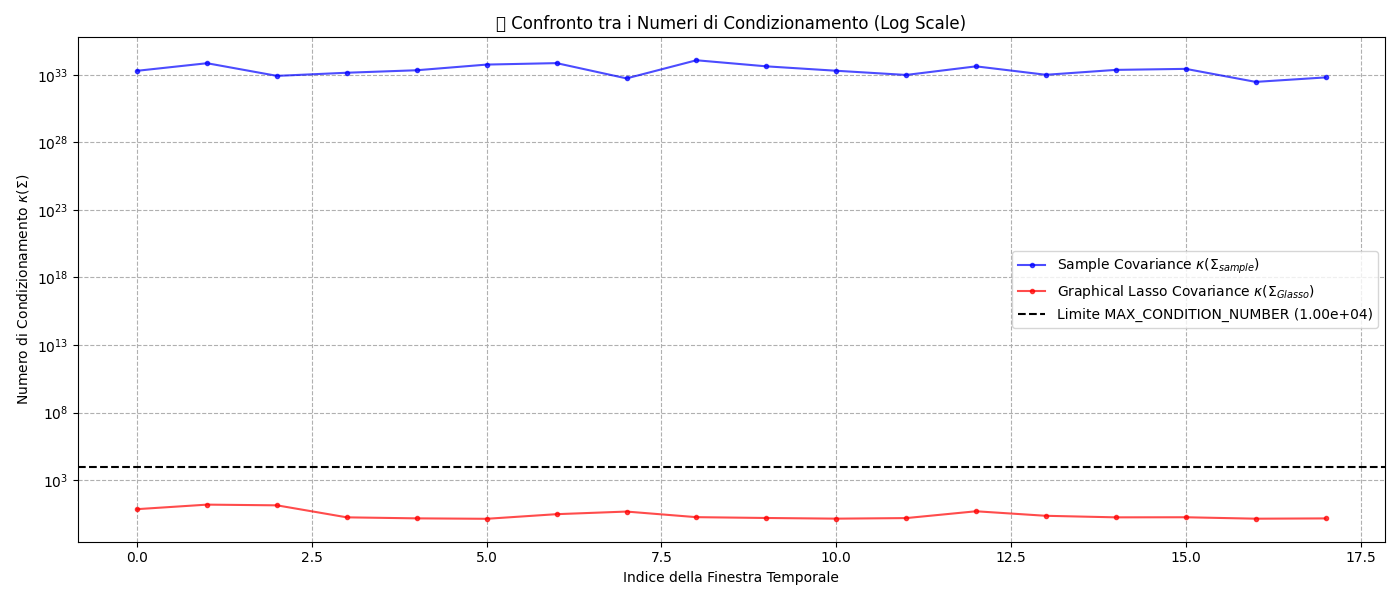


--- Analisi Dettagliata del Condizionamento ---
Limite MAX_CONDITION_NUMBER utilizzato: 1.00e+04
Numero totale di finestre: 18
----------------------------------------
Finestre mal condizionate (Campione): 18 (100.00%)
Finestre mal condizionate (Glasso): 0 (0.00%)


In [ ]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.

MAX_CONDITION_NUMBER = 1e4  # threshold to consider a matrix "well-conditioned"


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf

    sample_prec = None
    # is_well_conditioned = np.isfinite(cond_sample) and cond_sample < MAX_CONDITION_NUMBER

    try:
        sample_prec = np.linalg.inv(sample_cov)
    except np.linalg.LinAlgError as e:
        print(
            "Warning:"
            f"(cond={cond_sample:.2e}) and inversion failed;\n"
            f"  Details: {e}"
        )
        sample_prec = None


    # --- LEDOIT–WOLF COVARIANCE FOR GLASSO INPUT ---
    # We use standardized data and assume it is centered.
    emp_cov, _ = ledoit_wolf(X, assume_centered=True)

    # --- GRAPHICAL LASSO ---
    glasso_cov, glasso_prec = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
    
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, cond_sample, sample_prec, glasso_cov, cond_glasso, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
cond_sample = []
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices
cond_glasso = []

for idx, win in enumerate(windows):
    s_cov, s_cond, s_prec, g_cov, g_cond, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    cond_sample.append(s_cond)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    cond_glasso.append(g_cond)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)
    

# --- 2. Funzione di Plotting e Analisi ---

window_indices = np.arange(len(cond_sample))

plt.figure(figsize=(14, 6))

# Plot dei valori di condizionamento campionari
plt.plot(window_indices, cond_sample, label='Sample Covariance $\\kappa(\\Sigma_{sample})$', marker='.', linestyle='-', color='blue', alpha=0.7)

# Plot dei valori di condizionamento Glasso
plt.plot(window_indices, cond_glasso, label='Graphical Lasso Covariance $\\kappa(\\Sigma_{Glasso})$', marker='.', linestyle='-', color='red', alpha=0.7)

# Linea orizzontale per il limite di mal condizionamento
plt.axhline(MAX_CONDITION_NUMBER, color='k', linestyle='--', label=f'Limite MAX_CONDITION_NUMBER ({MAX_CONDITION_NUMBER:.2e})')

# Impostazioni del grafico
plt.yscale('log') # Usa una scala logaritmica per vedere i grandi valori
plt.title('📈 Confronto tra i Numeri di Condizionamento (Log Scale)')
plt.xlabel('Indice della Finestra Temporale')
plt.ylabel('Numero di Condizionamento $\\kappa(\\Sigma)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Analisi del Condizionamento ---

# Controlla per i valori mal condizionati (condizionamento > Limite)
num_windows = len(window_indices)
num_sample_ill = np.sum(np.array(cond_sample) > MAX_CONDITION_NUMBER)
num_glasso_ill = np.sum(np.array(cond_glasso) > MAX_CONDITION_NUMBER)

print("\n--- Analisi Dettagliata del Condizionamento ---")
print(f"Limite MAX_CONDITION_NUMBER utilizzato: {MAX_CONDITION_NUMBER:.2e}")
print(f"Numero totale di finestre: {num_windows}")
print("-" * 40)
print(f"Finestre mal condizionate (Campione): {num_sample_ill} ({num_sample_ill / num_windows * 100:.2f}%)")
print(f"Finestre mal condizionate (Glasso): {num_glasso_ill} ({num_glasso_ill / num_windows * 100:.2f}%)")


In [22]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute Frobenius norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = (cov_list[i+1] - cov_list[i])
        frob = np.linalg.norm(delta, ord='fro')/np.linalg.norm(cov_list[i], ord='fro')    # NORMALIZATION
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2023-01-04–2023-02-13 -> 2023-02-14–2023-03-15          1.041949   
1  2023-02-14–2023-03-15 -> 2023-03-16–2023-04-18          0.801321   
2  2023-03-16–2023-04-18 -> 2023-04-19–2023-06-09          0.904295   
3  2023-04-19–2023-06-09 -> 2023-06-14–2023-07-26          1.067124   
4  2023-06-14–2023-07-26 -> 2023-07-27–2023-09-11          1.223181   

   frobenius_glasso  
0          0.292778  
1          0.284749  
2          0.286316  
3          0.006218  
4          0.003096  

Summary statistics:
  mean(sample) : 1.0852741341466794
  mean(glasso) : 0.07915144734483659
  std(sample)  : 0.12301471083955579
  std(glasso)  : 0.1059391013153111


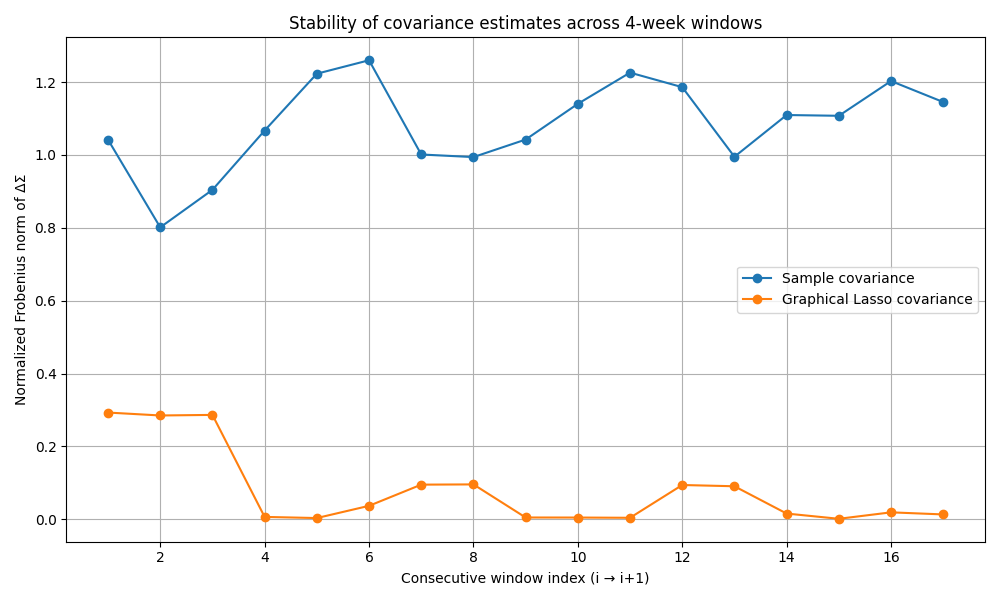

Stability comparison plot generated.


In [26]:
# Cell 6: Plot sample vs Glasso Frobenius norms

plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample) + 1)

plt.plot(x, fro_sample, marker='o', label="Sample covariance")
plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Normalized Frobenius norm of ΔΣ")
plt.title(f"Stability of covariance estimates across {WINDOW_WEEKS}-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Stability comparison plot generated.")


In [27]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
fro_sample_prec = frobenius_differences(sample_precs)
fro_glasso_prec = frobenius_differences(glasso_precs)

# Label window pairs i -> i+1
window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

prec_results_df = pd.DataFrame({
    "window_pair": window_pairs_prec,
    "frobenius_sample_prec": fro_sample_prec,
    "frobenius_glasso_prec": fro_glasso_prec,
})

print("Frobenius differences between consecutive windows (PRECISION matrices):")
print(prec_results_df.head())

print("\nSummary statistics for precision matrices:")
print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

# Plot the stability over window pairs
plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample_prec) + 1)

plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΘ  (precision)")
plt.title("Stability of precision estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Precision stability comparison plot generated.")


print(fro_sample_prec)
print(fro_glasso_prec)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

**Interpretation**: Why Condition Number Drives Stability

In our code, we calculated $\kappa_2(\Sigma)$ using np.linalg.cond, which computes the ratio of the largest to the smallest singular value via SVD ($\sigma_{max} / \sigma_{min}$).

When we move from window $t$ to $t+1$, the input covariance matrix $\Sigma$ changes slightly (perturbation). The condition number tells us how much that small change is amplified when we compute the inverse (Precision Matrix $\Omega = \Sigma^{-1}$).The theoretical bound on relative error is:$$\frac{\|\Delta \Sigma^{-1}\|}{\|\Sigma^{-1}\|} \leq \kappa(\Sigma) \cdot \frac{\|\Delta \Sigma\|}{\|\Sigma\|}$$

**Numerical Example from Our Results**:
1. When $\kappa_2(\Sigma)$ ~20,000: a tiny $5\%$ change in the input data (rolling the window forward) can be amplified up to $20,000 \times 0.05 = 1,000$ times (100,000%) in the inverse matrix. This explains why our consecutive Frobenius differences for the sample precision are massive (mean ~1,272). The solution is numerically unstable and jumps wildly.
2. The Graphical Lasso (Well-Conditioned): The regularization forced $\kappa$ down to ~2 to 5.The Mechanism: With a $\kappa \approx 3$, a $5\%$ change in input results in only a $3 \times 0.05 = 0.15$ (15%) change in the inverse. 

Observed Result: Our observed Frobenius differences are very small. The estimate is robust and evolves smoothly over time.